<a href="https://colab.research.google.com/github/flatneuron/Image-Identification/blob/main/similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#My Approach for similar image search using machine learning

In [ ]:
!pip install roboflow faiss-cpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.3 MB/s eta 0:00:00


In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet18
from PIL import Image
from roboflow import Roboflow
import faiss
from tqdm import tqdm


In [ ]:
# 1. Downloading COCO-128 dataset via Roboflow
rf = Roboflow(api_key="RTtMEx0CuGLDG9CTP1UW")
dataset = rf.workspace("team-roboflow").project("coco-128").version(2).download("coco")
ROOT = os.path.join(os.getcwd(), dataset.location, "train")
file_list = [os.path.join(ROOT, f) for f in os.listdir(ROOT) if f.lower().endswith('.jpg')]

# 2. creating two random augmentations per image
simclr_transforms = T.Compose([
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.4, 0.4, 0.4, 0.1),
    T.GaussianBlur(5),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to COCO-128-2 in coco:: 100%|██████████| 386/386 [00:00<00:00, 2992.85it/s]


In [ ]:
# 3. defining dataset class for the data
class SimCLRDataset(Dataset):
    def __init__(self, files, transform):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

# 4. defining the resnet18 model architecture with a different output layer for embeddings 128d vector
class ResNetSimCLR(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        base = resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(base.children())[:-1])  # remove fc
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x) # Removed .squeeze()
        h = h.view(h.size(0), -1) # Added view to flatten
        z = self.projector(h)
        return F.normalize(z, dim=1)

# 5. loss functions based on cosine similarity and cross entropy
def info_nce_loss(z1, z2, temperature=0.1):
    batch_size = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / (temperature + 1e-8)
    labels = torch.arange(batch_size).to(z.device)
    labels = torch.cat([labels, labels], dim=0)
    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(z.device)
    sim = sim.masked_fill(mask, -9e15)
    return F.cross_entropy(sim, labels)

# 6. Training loop
def train_simclr(model, dataloader, optimizer, device, epochs=20):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x1, x2 in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x1, x2 = x1.to(device), x2.to(device)
            z1, z2 = model(x1), model(x2)
            loss = info_nce_loss(z1, z2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss={total_loss/len(dataloader):.4f}")

In [ ]:
# 7. Build dataset and dataloader
dataset = SimCLRDataset(file_list, simclr_transforms)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# 8. Instantiate model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetSimCLR(out_dim=128)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 9. Train
train_simclr(model, dataloader, optimizer, device, epochs=30)



This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]
Epoch 1/30: 100%|██████████| 2/2 [00:08<00:00,  4.37s/i

Epoch 1: Loss=4500000176340992.0000


Epoch 2/30: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch 2: Loss=4500000176340992.0000


Epoch 3/30: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Epoch 3: Loss=4500000176340992.0000


Epoch 4/30: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


Epoch 4: Loss=4500000176340992.0000


Epoch 5/30: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Epoch 5: Loss=4500000176340992.0000


Epoch 6/30: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


Epoch 6: Loss=4500000176340992.0000


Epoch 7/30: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Epoch 7: Loss=4500000176340992.0000


Epoch 8/30: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]


Epoch 8: Loss=4500000176340992.0000


Epoch 9/30: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


Epoch 9: Loss=4500000176340992.0000


Epoch 10/30: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch 10: Loss=4500000176340992.0000


Epoch 11/30: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


Epoch 11: Loss=4500000176340992.0000


Epoch 12/30: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


Epoch 12: Loss=4500000176340992.0000


Epoch 13/30: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Epoch 13: Loss=4500000176340992.0000


Epoch 14/30: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Epoch 14: Loss=4500000176340992.0000


Epoch 15/30: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


Epoch 15: Loss=4500000176340992.0000


Epoch 16/30: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


Epoch 16: Loss=4500000176340992.0000


Epoch 17/30: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Epoch 17: Loss=4500000176340992.0000


Epoch 18/30: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Epoch 18: Loss=4500000176340992.0000


Epoch 19/30: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


Epoch 19: Loss=4500000176340992.0000


Epoch 20/30: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


Epoch 20: Loss=4500000176340992.0000


Epoch 21/30: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


Epoch 21: Loss=4500000176340992.0000


Epoch 22/30: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


Epoch 22: Loss=4500000176340992.0000


Epoch 23/30: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


Epoch 23: Loss=4500000176340992.0000


Epoch 24/30: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch 24: Loss=4500000176340992.0000


Epoch 25/30: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch 25: Loss=4500000176340992.0000


Epoch 26/30: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch 26: Loss=4500000176340992.0000


Epoch 27/30: 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


Epoch 27: Loss=4500000176340992.0000


Epoch 28/30: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Epoch 28: Loss=4500000176340992.0000


Epoch 29/30: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


Epoch 29: Loss=4500000176340992.0000


Epoch 30/30: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

Epoch 30: Loss=4500000176340992.0000


In [ ]:
# 10. Build FAISS index over trained embeddings
def compute_embeddings(files, model, device):
    model.eval()
    emb_dict = {}
    embeddings = []
    for f in tqdm(files, desc="Embedding images"):
        img = Image.open(f).convert('RGB')
        x = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(),
                       T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])])(img).unsqueeze(0)
        with torch.no_grad():
            z = model(x.to(device)).cpu().numpy()
        emb_dict[f] = z.tolist()
        embeddings.append(z)
    all_emb = np.vstack(embeddings)
    return all_emb, emb_dict

import numpy as np
torch.save(model.state_dict(), "resnet_simclr_coco128.pt")

all_emb, emb_dict = compute_embeddings(file_list, model, device)
index = faiss.IndexFlatL2(all_emb.shape[1])
index.add(all_emb)
with open("embeddings_map.json", "w") as f:
    json.dump(emb_dict, f)
faiss.write_index(index, "coco128_resnet_index.bin")

# 10. Query function
def search(query_img_path, model, index, emb_map, k=5):
    model.eval()
    img = Image.open(query_img_path).convert('RGB')
    x = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(),
                   T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])])(img).unsqueeze(0)
    with torch.no_grad():
        q_emb = model(x.to(device)).cpu().numpy()
    D, I = index.search(q_emb, k)
    results = [list(emb_map.keys())[i] for i in I[0]]
    return results

Embedding images: 100%|██████████| 128/128 [00:01<00:00, 94.02it/s] 


In [ ]:
results = search(file_list[0], model, index, emb_dict, k=3)
print(results)

['/content/COCO-128-2/train/000000000419_jpg.rf.b58c3291ae18177c82e19195fd533614.jpg', '/content/COCO-128-2/train/000000000382_jpg.rf.c172a50ccf4da06a423497fac9d12579.jpg', '/content/COCO-128-2/train/000000000389_jpg.rf.1dd437dbb518e480b21652cf552e5b2d.jpg']


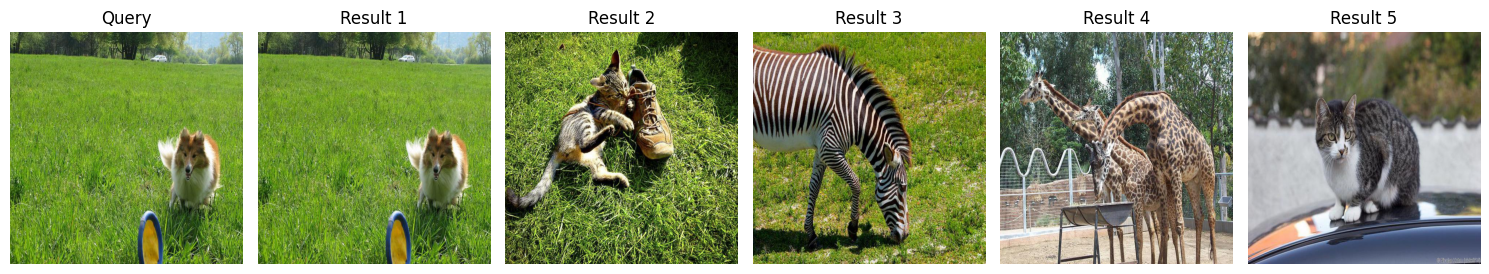

In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_images(query_path, result_paths):
    plt.figure(figsize=(15, 15))

    # Show the query image
    img = cv2.imread(query_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(result_paths) + 1, 1)
    plt.imshow(img)
    plt.title("Query")
    plt.axis("off")

    # Show result images
    for i, path in enumerate(result_paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(result_paths) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Result {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example Usage
query_img = file_list[44]
top_k = 5

results = search(query_img, model, index, emb_dict, k=top_k)
show_images(query_img, results)
